In [1]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from pyscf import gto, scf
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# Build network - number of electrons, 1d functions, spin interation/feature

# Initialize functions considering nuclear and electronic info...
# Loss function for electronic structure, i.e. Schrodinger Equation
# VMC/MCMC for sampling functions and updating parameters through loss function evaluation/expectation value
# Update positions and functions

In [ ]:
# Input for nuclear positions. From FermiNet configs
BOND_LENGTHS = {
    'BeH': 1.348263,
    'CN': 1.134797,
    'ClF': 1.659091,
    'F2': 1.420604,
    'H2': 0.737164,
    'HCl': 1.2799799,
    'Li2': 2.77306,
    'LiH': 1.639999,
    'N2': 1.129978,
    'NH': 1.039428,
    'CO': 1.150338
}

In [4]:
# # Create molecule
mol = gto.M(
   atom = 'H 0 0 0;', # H 0 0 0.737164;',
   basis = 'sto-3g',
   spin = 1
)
# Total number of electrons
total_electrons = mol.nelectron

# Correct way to get atom symbols
nuclear_charges = mol.atom_charges()

def parse_atom_string(mol):
   # Split the atom string by semicolons
   atom_sections = mol.atom.split(';')
   
   # For each section, get the first alphabetic character(s)
   atoms = []
   for section in atom_sections:
       # Skip empty sections
       if section.strip():
           # Get first part of section (before numbers)
           atom_symbol = section.strip().split()[0]
           # Only add if it's an atomic symbol (letters only)
           if atom_symbol.isalpha():
               atoms.append(atom_symbol)
   
   return atoms

def create_unique_atom_dict(atoms, nuclear_charges):
    # Count occurrences of each atom
    atom_count = Counter()
    unique_atoms = []
    
    # Create unique keys for repeated atoms
    for atom in atoms:
        atom_count[atom] += 1
        if atom_count[atom] == 1:
            unique_atoms.append(atom)
        else:
            unique_atoms.append(f"{atom}_{atom_count[atom]}")
    
    # Create dictionary with unique keys
    return dict(zip(unique_atoms, nuclear_charges))

atoms = parse_atom_string(mol)
nuclear_charges = mol.atom_charges().tolist()

atom_charges = {f"{atom}_{i+1}" if atoms.count(atom) > 1 else atom: charge 
                for i, (atom, charge) in enumerate(zip(atoms, nuclear_charges))}

print(atom_charges) 

# Spin number info - fix spins by Hund's Rule, spin not present in Born-Oppenheimer Approx. 
# Learnable spins not needed/can be hard coded
# spin_up = mol.nelectron // 2  # Number of spin-up electrons
# spin_down = mol.nelectron // 2   # Number of spin-down electrons


{'H': 1}


In [5]:
# Total number of electrons
NUM_ELECTRONS = total_electrons
INPUT_DIM = NUM_ELECTRONS
OUTPUT_DIM = NUM_ELECTRONS


# Create MultKAN model with specified widths
# Create the initial MultKAN model

#model = MultKAN(width=[1,[0,1],1], grid=5, k=3, seed=42, mult_arity=2)
model = KAN(width=[1,1], grid=5, k=3, seed=0)

# Create dataset
f = lambda x:  (1 / np.sqrt(32 * np.pi)) * (2 - x[:,[0]]) * torch.exp((-1/2) * x[:,[0]]) 
dataset = create_dataset(f, n_var=1, ranges=[0,20], train_num=10000)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

checkpoint directory created: ./model
saving model version 0.0
Dataset shapes: torch.Size([10000, 1]) torch.Size([10000, 1])


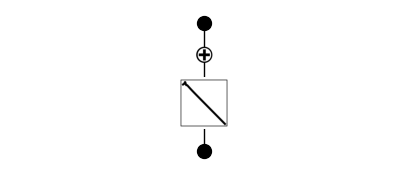

In [6]:
# def chain_str(in_out_dim: int, num_electrons: int) -> str:
#     connection_idxs = list(range(in_out_dim))

#     # Get first, second, and third third of input indices
#     radial_indices = connection_idxs[0::3]
#     theta_indices = connection_idxs[1::3]
#     phi_indices = connection_idxs[2::3]

#     # Get output indices with remainders 0, 1, and 2 when divided by 3
#     radial_electrons = [i for i in range(in_out_dim) if i % 3 == 0]
#     theta_electrons = [i for i in range(in_out_dim) if i % 3 == 1]
#     phi_electrons = [i for i in range(in_out_dim) if i % 3 == 2]

#     # Create three chains
#     first_chain = f'{radial_electrons}->{radial_indices}'
#     second_chain = f'{theta_electrons}->{theta_indices}'
#     third_chain = f'{phi_electrons}->{phi_indices}'

#     return [first_chain, second_chain, third_chain]

# chains = chain_str(INPUT_DIM, NUM_ELECTRONS)

# # Set up all connections
# for chain in chains:
#     model.module(0, chain)
       
# # # Create chain for final layer where all intermediate nodes connect to output
# final_indices = list(range(OUTPUT_DIM))
# final_chain = f'{final_indices}->[0]'
# model.module(1, final_chain)

# radial_vars = [r'$r_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]
# theta_vars = [r'$\theta_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]
# phi_vars = [r'$\phi_{'+str(i)+'}$' for i in range(NUM_ELECTRONS)]

# input_vars = radial_vars + theta_vars + phi_vars

model(dataset['train_input'])
model.plot(beta=10)

In [233]:
model.fit(dataset, steps=50, lamb=0.001);

| train_loss: 4.15e-03 | test_loss: 4.22e-03 | reg: 2.11e+00 | : 100%|█| 50/50 [00:01<00:00, 47.04it

saving model version 0.1


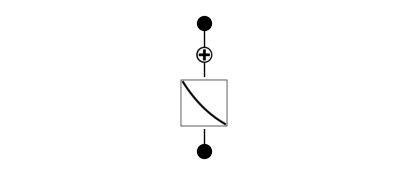

In [234]:
model.plot()

saving model version 0.2


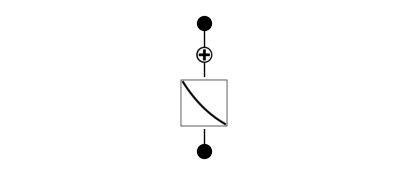

In [235]:
model = model.prune()
model.plot()

In [236]:
    # if i == 0:
    #     model = MultKAN(width=[INPUT_DIM, [0, OUTPUT_DIM], 1],  grid=grids[i], k=5, seed=42)#, mult_arity=3)

    # if i != 0:

grids = np.array([3,10,20,50])

train_losses = []
test_losses = []
steps = 20

for i in range(grids.shape[0]):
        model = model.refine(grids[i])
        results = model.fit(dataset, opt="LBFGS", steps=steps)
        train_losses += results['train_loss']
        test_losses += results['test_loss']

saving model version 0.3


| train_loss: 3.91e-06 | test_loss: 3.86e-06 | reg: 2.15e+00 | : 100%|█| 20/20 [00:00<00:00, 40.88it


saving model version 0.4
saving model version 0.5


| train_loss: 9.48e-07 | test_loss: 9.68e-07 | reg: 2.15e+00 | : 100%|█| 20/20 [00:01<00:00, 19.82it


saving model version 0.6
saving model version 0.7


| train_loss: 7.46e-08 | test_loss: 7.24e-08 | reg: 2.15e+00 | : 100%|█| 20/20 [00:00<00:00, 28.97it


saving model version 0.8
saving model version 0.9


| train_loss: 3.24e-08 | test_loss: 3.21e-08 | reg: 2.15e+00 | : 100%|█| 20/20 [00:01<00:00, 11.42it

saving model version 0.10


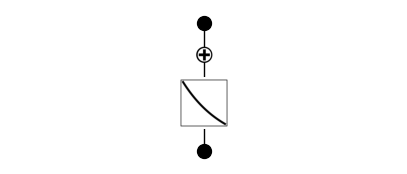

In [237]:
model.plot()

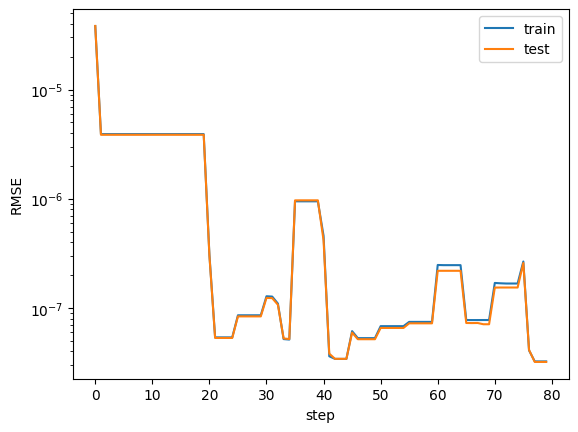

In [238]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [239]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['exp', 'x', 'x^2']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with exp, r2=1.0000003576278687, c=2
saving model version 0.11


In [240]:
sf = model.symbolic_formula()[0][0]

In [241]:
nsimplify(ex_round(sf, 4))

1/2500 + 2819*exp(-x_1)/5000

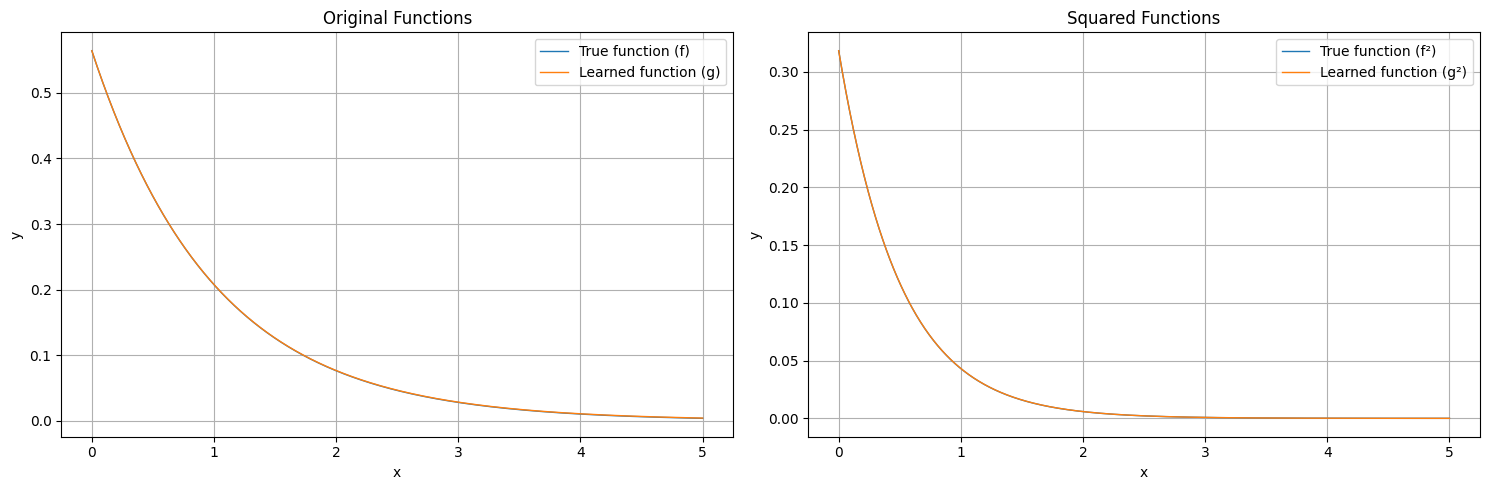

Mean Squared Error: 0.0000001132


In [250]:
x = np.linspace(0, 5, 1000).reshape(-1, 1)

# Regular functions
f = np.exp(-x) / np.sqrt(np.pi)
g = 1/2500 + (2819/5000) * np.exp(-x)

# Squared functions
f_squared = f**2
g_squared = g**2

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Regular functions plot
ax1.plot(x, f, label='True function (f)', linewidth=1)
ax1.plot(x, g, label='Learned function (g)', linewidth=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Original Functions')
ax1.legend()
ax1.grid(True)

# Squared functions plot
ax2.plot(x, f_squared, label='True function (f²)', linewidth=1)
ax2.plot(x, g_squared, label='Learned function (g²)', linewidth=1)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Squared Functions')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Calculate and print MSE
mse = np.mean((f - g) ** 2)
print(f"Mean Squared Error: {mse:.10f}")